In [6]:
import os.path

import dftqml.utils
import matplotlib.pyplot as plt
import numpy as np

KS_DIR = "../main/kohn-sham"
DATA_DIR = "../main/data-h5"
INITS = ["cheat", "random", "uniform"]
N_SPLITS = 5
EXACT = "exact"
N_DATA_MODEL = 1000
N_DATA_TEST = 1000
POTENTIALS = "potentials.h5"

def data_path(L, N, U, source):
    return os.path.join(DATA_DIR, f"L{L}-N{N}-U{U}", source)


def ks_path(L, N, U, source, init, split):
    return os.path.join(
        KS_DIR, init, f"L{L}-N{N}-U{U}", source, f"ndata{N_DATA_TEST}", f"split{split}"
    )


def load_ks(L, N, U, source, init, split, *, potentials):
    densities, energies =  dftqml.utils.load_dft_data(
        ks_path(L, N, U, source, init, split), N_DATA_TEST, first_idx=N_DATA_MODEL
    )
    energies = energies[:, 0]  # TODO remove once script is fixed
    return densities, energies

def get_potential_energies(potentials, densities):
    return np.einsum('ij,ij->i', potentials, densities)

In [7]:
L = 8
N = 4
U = 4.0

exact_densities, exact_energies = dftqml.utils.load_dft_data(
    data_path(L, N, U, EXACT), N_DATA_TEST, N_DATA_MODEL
)

potentials = dftqml.utils.load_potentials(data_path(L, N, U, POTENTIALS), N_DATA_TEST, N_DATA_MODEL)
potential_std = np.std(potentials, axis=1)

# Energy error

In [8]:
def energy_error_plots(source, error_threshold, split=0):
    ms = 3
    fig, axes = plt.subplots(2, len(INITS), figsize=(9, 7), sharey = 'row')

    for i, init in enumerate(INITS):
        ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials)
        energy_errors = ks_energies - exact_energies
        npts_below_threshold = np.sum(np.abs(energy_errors) < error_threshold)
        
        axes[0, i].plot(exact_energies, energy_errors, ".", ms=ms, label = 'positive error')
        axes[0, i].plot(exact_energies, -energy_errors, ".", ms=ms, label = 'negative error')
        axes[0, i].axhline(0, color="black", ls=":")
        axes[0, i].axhline(error_threshold, color="red", ls=":", label='error threshold')
        axes[0, i].axhline(-error_threshold, color="red", ls=":")
        axes[0, i].set_xlabel("exact energy")
        
        axes[0, i].set_title(f'{init} initialization\n'
                            f'{npts_below_threshold/N_DATA_TEST:.0%} errors are below {error_threshold}')
        
        axes[1, i].plot(potential_std, energy_errors, ".", ms=ms)
        axes[1, i].plot(potential_std, -energy_errors, ".", ms=ms)
        axes[1, i].axhline(0, color="black", ls=":")
        axes[1, i].axhline(error_threshold, color="red", ls=":", label='error threshold')
        axes[1, i].set_xlabel("stddev of potential")

    axes[0, 0].set_ylabel("KS energy error")
    axes[0, 0].legend()
    axes[0, 0].set_yscale("log")
    axes[0, 0].set_ylim(bottom=1e-5)

    axes[1, 0].set_ylabel("KS energy error")
    axes[1, 0].set_yscale("log")
    axes[1, 0].set_ylim(bottom=1e-5)

    plt.subplots_adjust(wspace=0, hspace=0.3)
    return fig

# Density error

In [9]:
def density_error_plots(source, error_threshold):
    ms = 3
    fig, axes = plt.subplots(1, len(INITS), figsize=(9, 4), sharey = 'row')

    for i, init in enumerate(INITS):
        ks_densities, ks_energies = load_ks(L, N, U, source, init, 0, potentials=potentials)
        density_errors = np.sqrt(np.sum((ks_densities - exact_densities)**2, axis=1))
        npts_below_threshold = np.sum(np.abs(density_errors) < error_threshold)

        axes[i].set_title(f'{init} initialization\n'
                            f'{npts_below_threshold/N_DATA_TEST:.0%} errors are below {error_threshold}')
        
        axes[i].plot(potential_std, density_errors, ".", ms=ms)

        axes[i].axhline(0, color="black", ls=":")
        axes[i].axhline(error_threshold, color="red", ls=":", label='error threshold')
        axes[i].set_xlabel("stddev of potential")

    axes[0].set_ylabel("KS density error")
    axes[0].legend()
    axes[0].set_yscale("log")
    axes[0].set_ylim(bottom=1e-3)
    
    plt.subplots_adjust(wspace=0)
    return fig

# Make bins

# Final plots

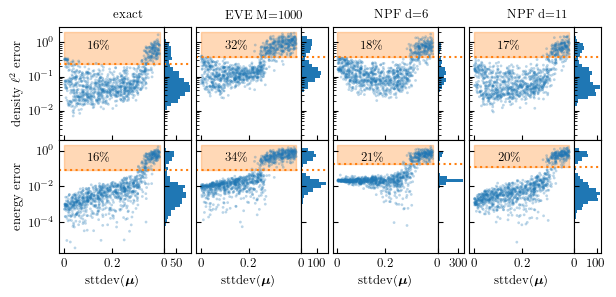

In [ ]:
sources = [
    "exact",
    "sampling/nshots1000",
    "npfabric-slsqp-init/depth6",
    "npfabric-slsqp-init/depth11",
]
titles = ["exact", "EVE M=1000", "NPF d=6", "NPF d=11"]
init = "random"
split = 0

plt.style.use("figstyle.mplstyle")
plt.rc('text.latex', 
       preamble=r'\usepackage{amsmath}')

hsize = 7.05
ms = 4
alpha = 0.3

fig, axes = plt.subplots(
    2,
    len(sources) * 2,
    figsize=(hsize, hsize / (2.5 * len(sources) * 1.2) * 5),
    sharey="row",
    sharex="col",
    gridspec_kw={"width_ratios": len(sources) * [10, 3], "hspace": 0, "wspace": 0},
)


# Create log-spaced bins
num_bins = 30
density_error_range = [0.002, 2]
energy_error_range = [0.00002, 2]

density_bins = np.logspace(
    np.log10(density_error_range[0]), np.log10(density_error_range[1]), num_bins
)
energy_bins = np.logspace(
    np.log10(energy_error_range[0]), np.log10(energy_error_range[1]), num_bins
)

histlist_dens = []
histlist_ener = []

thr_dens_binidx = [20, 22, 22, 22]  # chosen manually
thr_ener_binidx = [21, 21, 23, 22]  # chosen manually


for i, source in enumerate(sources):
    ks_densities, ks_energies = load_ks(L, N, U, source, init, split, potentials=potentials)
    density_errors = np.sqrt(np.sum((ks_densities - exact_densities) ** 2, axis=1))
    energy_errors = np.abs(ks_energies - exact_energies)

    # *** scatterplots ***
    axes[0, i * 2].scatter(potential_std, density_errors, s=ms, alpha=alpha, ec="none")
    axes[1, i * 2].scatter(potential_std, energy_errors, s=ms, alpha=alpha, ec="none")

    # *** histograms ***
    hist_val, _, _ = axes[0, i * 2 + 1].hist(
        density_errors, orientation="horizontal", bins=density_bins
    )
    histlist_dens.append(hist_val)

    hist_val, _, _ = axes[1, i * 2 + 1].hist(
        energy_errors, orientation="horizontal", bins=energy_bins
    )
    histlist_ener.append(hist_val)

    # *** density threshold ***
    density_thr = density_bins[thr_dens_binidx[i]]
    ndata_over_thr = np.sum(density_errors > density_thr)

    axes[0, i * 2].fill_betweenx(
        [density_thr, density_bins[-1]], 0, np.max(potential_std), color="C1", alpha=0.3, zorder=-1
    )
    axes[0, i * 2].text(
        0.1,
        0.8,
        f"${ndata_over_thr/N_DATA_TEST*100:.0f}\%$",
        va="center",
    )
    axes[0, i * 2].axhline(density_thr, color="C1", ls=":")
    axes[0, i * 2 + 1].axhline(density_thr, color="C1", ls=":")

    # *** energy threshold ***
    energy_thr = energy_bins[thr_ener_binidx[i]]
    ndata_over_thr = np.sum(energy_errors > energy_thr)

    axes[1, i * 2].fill_betweenx(
        [energy_thr, energy_bins[-1]], 0, np.max(potential_std), color="C1", alpha=0.3, zorder=-1
    )
    axes[1, i * 2].text(
        0.1,
        0.4,
        f"${ndata_over_thr/N_DATA_TEST*100:.0f}\%$",
        va="center",
    )
    axes[1, i * 2].axhline(energy_thr, color="C1", ls=":")
    axes[1, i * 2 + 1].axhline(energy_thr, color="C1", ls=":")

    # *** labels and titles ***

    axes[1, i * 2].set_xlabel(r"sttdev($\boldsymbol{\mu}$)")
    axes[0, i * 2].set_title(titles[i], x=0.65)

    axes[1, i * 2].set_xticks([0, 0.2], ["0", "0.2"])

axes[1, 1].set_xticks([0, 50])
axes[1, 5].set_xticks([0, 300])

axes[0, 0].set_yscale("log")
axes[0, 0].set_ylabel("density $\ell^2$ error")
axes[1, 0].set_yscale("log")
axes[1, 0].set_ylabel("energy error")

# plt.subplots_adjust(wspace=0, hspace=0)


# Add space between specific subplots
for i in range(1, len(sources) * 2, 2):
    for j in range(2):
        box = axes[j, i].get_position()
        box.x0 -= 0.00  # Add space to the left of the subplot
        box.x1 -= 0.007  # Add space to the right of the subplot
        axes[j, i].set_position(box)

# plt.savefig("plots/kohn-sham.pdf", bbox_inches="tight")
plt.show()
